# Objective

Build a recommendation system to recommend products to  customers based on the their  previous ratings for other  products.  

# Load Libraries and Data

Loading Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns

Loading Data

In [38]:
products = pd.read_csv("D://Great learning//Datasets//ratings_Electronics.csv")

# Data Pre processing

In [39]:
products.columns = ['userid','productid','rating','timestamp']

In [4]:
products.head()

,userid,productid,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [40]:
products.drop('timestamp',axis=1,inplace=True)

In [6]:
products.head()

,userid,productid,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [7]:
products.shape

(7824481, 3)

In [8]:
products.describe(include='all')

,userid,productid,rating
count,7824481,7824481,7.824481e+06
unique,4201696,476001,NaN
top,A5JLAU2ARJ0BO,B0074BW614,NaN
freq,520,18244,NaN
mean,NaN,NaN,4.012337e+00
std,NaN,NaN,1.380910e+00
min,NaN,NaN,1.000000e+00
25%,NaN,NaN,3.000000e+00
50%,NaN,NaN,5.000000e+00
75%,NaN,NaN,5.000000e+00


In [9]:
products.isnull().sum()

userid       0
productid    0
rating       0
dtype: int64

Observations:

    we dont have any missing values.
    we have the product 'A5JLAU2ARJ0BO' most occured in the dataset with frequency of 520

Check for duplicate data

In [10]:
dups = products.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

products[dups]

Number of duplicate rows = 0


,userid,productid,rating


In [11]:
ratings_explicit = products[products.rating != 0]
print(ratings_explicit.shape)

(7824481, 3)


There are no zero ratings

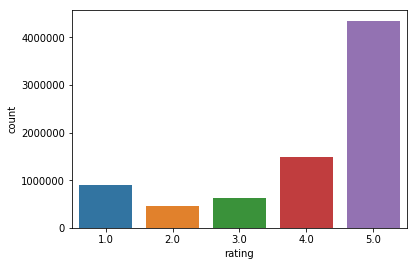

In [12]:
sns.countplot(data=ratings_explicit , x='rating')
plt.show()

It can be seen that higher ratings are more common amongst users and rating 5 has been rated highest number of times

In [42]:
#view first few items with their average rating
products.groupby('userid')['rating'].mean().head()

userid
A00000262KYZUE4J55XGL    5.0
A000063614T1OE0BUSKUT    5.0
A00009182QVLSWIGHLS1B    5.0
A00009661LC9LQPGKJ24G    5.0
A00010809P09NUU6ZP6H     5.0
Name: rating, dtype: float64

In [44]:
#lets view the same in sorted order
products.groupby('productid')['rating'].mean().sort_values(ascending=False).head()

productid
BT008V9J9U    5.0
B0058PRC0S    5.0
B0058ORBFU    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
Name: rating, dtype: float64

In [45]:
#Now lets view the items based on total number of ratings
products.groupby('productid')['rating'].count().sort_values(ascending=False).head()

productid
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: rating, dtype: int64

In [118]:
#Both the average rating per item and the number of ratings per item are important attributes. Let's create a new dataframe that contains both of these attributes.
ratings_mean_count = pd.DataFrame(products.groupby('productid')['rating'].mean())

In [119]:
ratings_mean_count.head()

,rating
productid,
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852
0558835155,3.000000


In [120]:
ratings_mean_count['rating_counts'] = pd.DataFrame(products.groupby('productid')['rating'].count())

In [121]:
ratings_mean_count.head()

,rating,rating_counts
productid,,
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27
0558835155,3.000000,1


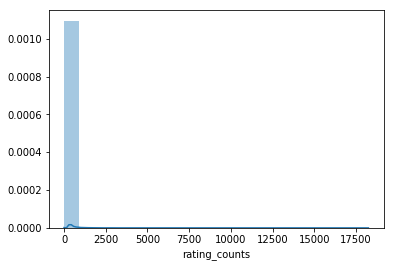

In [114]:
sns.distplot(ratings_mean_count['rating_counts'],bins=20)

There are many items which has fewer number of ratings. lets keep a cutoff to 50 to make the dataset less sparse

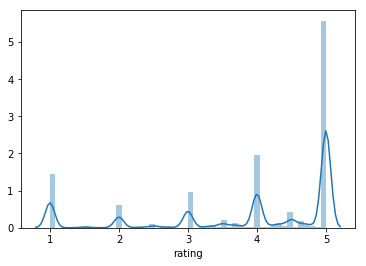

In [25]:
sns.distplot(ratings_mean_count['rating'])

integer values have taller bars than the floating values since most of the users assign rating as integer value

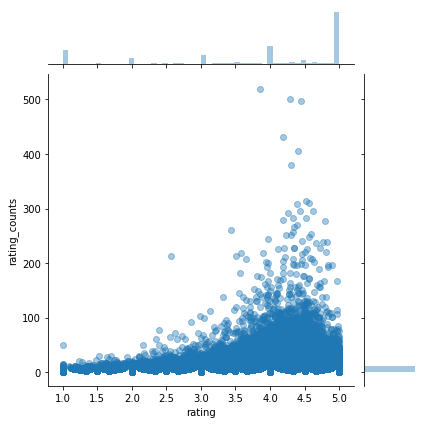

In [26]:
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

products with higher average ratings actually have more number of ratings, compared with items that have lower average ratings

# Build popularity based recommendation model

In [243]:
ratings_mean_count50=ratings_mean_count[ratings_mean_count['rating_counts']>50]

In [244]:
ratings_mean_count50.head()

,rating,rating_counts
productid,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


# Collabarative filtering

In [81]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [212]:
ratings_count = pd.DataFrame(products.groupby('userid')['rating'].count())
ratings_count.columns = ['ratings_count']

In [213]:
ratings_count.head()

,ratings_count
userid,
A00000262KYZUE4J55XGL,1
A000063614T1OE0BUSKUT,2
A00009182QVLSWIGHLS1B,1
A00009661LC9LQPGKJ24G,1
A00010809P09NUU6ZP6H,1


In [214]:
dataset_merged = products.merge(ratings_count, on='userid')

In [215]:
dataset_merged.head()

,userid,productid,rating,ratings_count
0,A2CX7LUOHB2NDG,0321732944,5.0,4
1,A2CX7LUOHB2NDG,B000W3LJ6Y,5.0,4
2,A2CX7LUOHB2NDG,B001EYU79A,5.0,4
3,A2CX7LUOHB2NDG,B0089MVZDW,4.0,4
4,A2NWSAGRHCP8N5,0439886341,1.0,1


In [216]:
dataset_merged.shape

(7824481, 4)

In [233]:
dataset_merged.loc[(dataset_merged.ratings_count < 200), 'ratings_count'] = np.nan

In [234]:
dataset_merged.dropna(inplace=True)

In [235]:
dataset_merged.shape

(13862, 4)

In [236]:
dataset_merged.columns = ['userid','productid','avgrating','ratings_count']

In [237]:
reader = Reader(rating_scale=(1, 5))

In [238]:
data = Dataset.load_from_df(dataset_merged[['userid', 'productid', 'avgrating']], reader)

In [239]:
trainset, testset = train_test_split(data, test_size=.30)

In [265]:
algo = KNNWithMeans(k=5, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [266]:
test_pred = algo.test(testset)

In [267]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.0152


1.0151955929523597

In [268]:
test_pred

[Prediction(uid='A23GFTVIETX7DS', iid='B00DS5QZRQ', r_ui=5.0, est=4.814437929868079, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AVPNQUVZWMDSX', iid='B00GRNUO2I', r_ui=4.0, est=4.624987268714989, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00078NIOA', r_ui=5.0, est=4.300113366999897, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3OXHLG6DIBRW8', iid='B007Y4TTWK', r_ui=5.0, est=4.300113366999897, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A36K2N527TXXJN', iid='B002K40R6G', r_ui=5.0, est=4.300113366999897, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2NOW4U7W3F7RI', iid='B00JBJZFLU', r_ui=5.0, est=4.300113366999897, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A31N0XY2UTB25C', iid='B001IDYKYK', r_ui=3.0, est=4.300113366999897, d

our goal is to  recommend new products for each user based on his/her  habits, we will recommend 5 new products. 